In [2]:
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.optimize import curve_fit
import os

def lineal(x, a, b):
  return a*x + np.log(b)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Leemos el archivo
myFolder=(os.getcwd()+'/tc01_data/') #busca en el directorio actual

# Primero creamos la red: 
colab = nx.read_gml(myFolder+'netscience.gml')
#net= nx.read_gml(myFolder+'as-22july06.gml')


In [4]:
#eliminamos nodos aislados:
aislados=list(nx.isolates(colab))
colab.remove_nodes_from(aislados)

#Matriz de Adjacencia Aij:
C_adj = nx.to_numpy_matrix(colab) 
#N_adj = nx.to_numpy_matrix(net)

nodos = colab.number_of_nodes()
#nodosN = net.number_of_nodes()

In [5]:
#i)
# k_nodo es el vector de grado de cada nodo
# knn_nodo es el valor, de grado promedio de vecinos de cada nodo
k_nodo= [val for (node, val) in colab.degree()]
knn_nodo=np.zeros(len(k_nodo))

for i in range(len(k_nodo)):
        knn_nodo[i] = np.dot(np.array(C_adj[i,:]), np.array(k_nodo)) / int(k_nodo[i]) #k_nodo[i] numero de vecinos propios para promediar.


/home/danilo/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/danilo/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


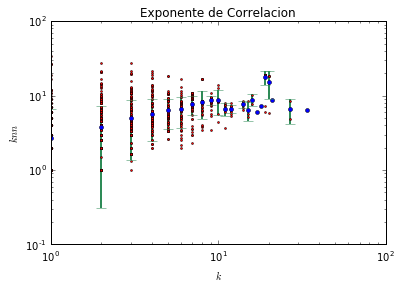

In [7]:
#ii)Grafico de knn en funcion del grado k:
#Tenemos que promediar:

#Ordenar el knn_nodo en funcion del key del k_nodo
knn_nodo=[x for _,x in sorted(zip(k_nodo,knn_nodo))]
knn_nodo=np.array(knn_nodo) 
#Ordenamos el k_nodo
k_nodo=np.sort(k_nodo)

#k es el vector de grados
k=np.unique(k_nodo)
knn=np.zeros(len(k))
knn_error=np.zeros(len(k))

for i,j in enumerate(k):
    v=np.where(k_nodo==j)
    knn[i]=np.mean(knn_nodo[v])
    knn_error[i]=np.std(knn_nodo[v],ddof=1)#ddof=significa degree of freedom en el calculo de la desviacion standar.
                                           #Creo que es mejor con ddof=1 porque si es un solo valor(el error no estaria definido)
                                           #y entonces asigna correctamente 

            
##Nos quedamos con puntos que tengan knn_error != nan
nonan_positions=[i for i,j in enumerate(knn_error) if np.invert(np.isnan(j))==True]
knn_error=knn_error[nonan_positions]
knn_fit=knn[nonan_positions]
k_fit=k[nonan_positions]          
            
plt.figure(1)        
plt.plot(k_nodo,knn_nodo,'ro',markersize=2)    
plt.plot(k,knn,'bo',markersize=4)
plt.errorbar(k_fit,knn_fit,knn_error,fmt='.',ecolor='seagreen',elinewidth=2,capsize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$knn$')
plt.xlim(0,100)
plt.title('Exponente de Correlacion')
plt.show()
    


In [8]:
#iii) Ajuste: con funcion log(knn)=mu*(logk)+log(b)

#AJuste 1: usando los puntos rojos
parametros1=curve_fit(lineal,np.log(k_nodo),np.log(knn_nodo))[0]
mu1=parametros1[0]
b1=parametros1[1]
intercept1=np.log(b1)

print ('Ajuste rojo')
print ('exponente = {}'.format(mu1))
print ('intercept = {}'.format(intercept1))

xfit1=np.linspace(1,40,100)
yfit1=(b1)*(xfit1**mu1)

#AJuste 2: usando los puntos azules del grafico knn(k) y usando tambien el error:
parametros2=curve_fit(lineal,np.log(k_fit),np.log(knn_fit),sigma=(1/knn_fit)*knn_error)[0]
mu2=parametros2[0]
b2=parametros2[1]
intercept2=np.log(b2)

print ('Ajuste azul')
print ('exponente = {}'.format(mu2))
print ('intercept = {}'.format(intercept2))


xfit2=np.linspace(1,40,100)
yfit2=(b2)*(xfit2**mu2)

Ajuste rojo
exponente = 0.7078865481441874
intercept = 0.5903724863767672
Ajuste azul
exponente = 0.3169717833936861
intercept = 1.2858353087733727


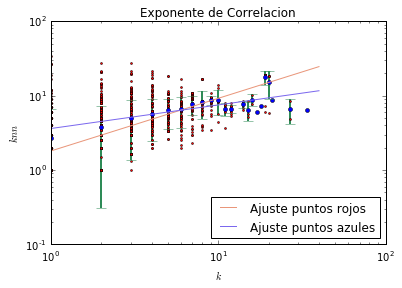

In [9]:
#Graficos
plt.figure(2)        
plt.plot(k_nodo,knn_nodo,'ro',markersize=2)    
plt.plot(k,knn,'bo',markersize=4)
plt.errorbar(k_fit,knn_fit,knn_error,fmt='.',ecolor='seagreen',elinewidth=2,capsize=5)
plt.plot(xfit1,yfit1,color='darksalmon',label='Ajuste puntos rojos')
plt.plot(xfit2,yfit2,color='mediumslateblue',label='Ajuste puntos azules')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$knn$')
plt.title('Exponente de Correlacion')
plt.legend(loc='lower right')
plt.show()


In [9]:
#iv)Asortividad con estimador de Newman:
#Segun el libro de Newman pág 267, eq-[8.26-8.29] se puede calcular r de la siguiente forma:
#r=(S1*Se-S2**2)/(S1*S3-S2**2)

S1=np.sum(k_nodo)
S2=np.sum(k_nodo**2)
S3=np.sum(k_nodo**3)

se=0
enlaces=list(colab.edges())
for i,e in enumerate(enlaces):
 se=se+colab.degree(enlaces[i][0])*colab.degree(enlaces[i][1])
Se=2*se

r=(S1*Se-S2**2)/float(S1*S3-S2**2)

print ('Asortatividad Barabasi (mu) = {}'.format(mu2))
print ('Asortatividad Newman (r) = {}'.format(r))

Asortatividad Barabasi (mu) = 0.3169717833936861
Asortatividad Newman (r) = 0.4616224667525835
